In [1]:
%matplotlib inline
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import random

In [2]:
from sklearn import preprocessing
from sklearn import feature_extraction
from sklearn import decomposition
from sklearn import neighbors
from sklearn import impute
from sklearn import linear_model
from sklearn import kernel_ridge
from sklearn import model_selection
from sklearn import metrics
from sklearn import pipeline
from sklearn import compose

# Create a class to create pandas dataframe from SQL queries

In [3]:
#Read data from JDBC server
class DB:
    def __init__(self):
        self.tables = None
        self.df = None
        self.point = None
        self.POSTGRES_HOST = "codd03.research.northwestern.edu"
        self.POSTGRES_PORT = 5432
        self.POSTGRES_DBNAME = 'cpdb'
        self.POSTGRES_USERNAME = 'cpdb_student'
        self.POSTGRES_PASSWORD = 'DataSci4Lyfe'
        self.postgres_str = ('postgresql://{username}:{password}@{host}:{port}/{dbname}'.format(username=self.POSTGRES_USERNAME,
                                                                                           password=self.POSTGRES_PASSWORD,
                                                                                           host=self.POSTGRES_HOST,
                                                                                           port=self.POSTGRES_PORT,
                                                                                           dbname=self.POSTGRES_DBNAME))
        self.engine = create_engine(self.postgres_str)

    def query(self, queryCommand):
            self.point = self.engine.execute(queryCommand)
            self.df = None
            try: self.df = pd.DataFrame([*self.point.mappings()])
            except Exception as msg:
                if msg == 'This result object does not return rows. It has been closed automatically.':pass
            return self.df

    def get_tables_from_commands(self, commands=None):
        self.tables = {}
        for command in commands:
            try:
                df = self.query(command)
                if df is not None:
                    self.tables[f't{len(self.tables.keys())}'] = {'frame': df, 'sql': command}
            except:
                pass
        return self.tables

def table_from_file(filename):
    obj = DB()
    t = obj.get_tables_from_commands
    with open(filename, 'r') as f:
        sqlFile = f.read()
    commands_raw = sqlFile.split(';')
    commands = []
    for command in commands_raw:
        q = f'''
        {command}
        '''
        commands.append(q)
    tables = t(commands)
    total = len(tables.keys())
    print(total, "tables received")
    del obj
    return (total, tables)

<br>

### Encoding/Decoding/cleaning helpers


In [4]:
def convert():
    # convert beats to sides
    filename = 'console0.sql'
    _, table = table_from_file(filename)

    # a dictionary that helps categorize beats to north or south
    temp_dict = table['t0']['frame'].to_dict('records')
    conversion_dict = {}
    for t in temp_dict:
        if t['name'] not in conversion_dict.keys():
            conversion_dict[t['name']] = t['side']
    return conversion_dict

conversion_dict = convert()

1 tables received


In [5]:
def kneighbours(beats):
    samples = list(conversion_dict.keys())
    neigh = neighbors.NearestNeighbors(n_neighbors=1)
    neigh.fit(np.reshape(np.array(samples), (-1, 1)))

    beats = np.reshape(np.array(list(beats)), (-1, 1))
    sample_idx = neigh.kneighbors(beats, return_distance=False)

    beatsNew = [ samples[i[0]] for i in sample_idx ]
    return beatsNew


### Preprocessing helpers

In [6]:
# keep columns which have more than 85% missing values
def remove_missing(data):
    columns = list(data.columns)
    print(f"Originallly {len(columns)} columns")
    missing = pd.DataFrame(data.isnull().sum())
    missing.reset_index(inplace=True)
    missing = missing.rename(columns = {'index':'columns', 0: 'null count'})
    missing["null count"] = missing["null count"].apply(lambda x: x*100/len(df1))
    remaining_columns = missing[missing["null count"] < 85.0]["columns"]
    print(f"Dropped to {len(remaining_columns)} columns by 85% rule")
    print(list(remaining_columns))
    return list(remaining_columns)

In [7]:
# imputation
zeroImputer = impute.SimpleImputer(strategy='constant', fill_value=0)
meanImputer = impute.SimpleImputer()

imputers = [('zero', zeroImputer), ('mean', meanImputer)]

In [8]:
# scaling
scalerST = preprocessing.StandardScaler()
scalerRB = preprocessing.RobustScaler()
scalers = [('std', scalerST), ('rb', scalerRB)]

### Feature Selection helpers

In [9]:
incrPCA = decomposition.IncrementalPCA()

### model selection helpers

In [10]:
# linear models

regrLinear = linear_model.LinearRegression()
regrRidge = linear_model.Ridge()
regrGamma = linear_model.GammaRegressor()
regrSGD = linear_model.SGDRegressor()



In [11]:
# kernal ridge
regrKernal = kernel_ridge.KernelRidge()


In [12]:
# classification

classLog = linear_model.LogisticRegression()

### Data visualization helpers

In [13]:
def plotLine(df, years):
    count = list(df["count"])
    plt.figure(figsize=(10,4))
    plt.plot(years, count)
    plt.xlabel("Year")
    plt.ylabel("trr report count")
    plt.show()

In [14]:
def barNS(df,years, name = "img.jpg"):
    barwidth = 0.3

    # years = df[df["side"]=='north']["years"] # same for south
    countNorth = df[df["side"]=='north']["count"]
    countSouth = df[df["side"]=='south']["count"]

    r1 = np.arange(len(countNorth))
    r2 = [x + barwidth for x in r1]

    fig = plt.subplots(figsize=(12, 3))
    plt.bar(r1, countNorth, width=barwidth, color='r', edgecolor="black", label="north")
    plt.bar(r2, countSouth, width=barwidth, color='g', edgecolor="black", label="south")
    plt.xlabel("year")
    plt.ylabel("trr count")
    plt.xticks([r + barwidth for r in range(len(countNorth))], years)
    plt.legend()
    plt.savefig("images\\"+name)
    plt.show()

def bar_pred_NS(df1, df2, years, name = "img.jpg"):
    barwidth = 0.7

    # years = df[df["side"]=='north']["years"] # same for south
    countNorth1 = df1[df1["side"]=='north']["count"]
    countNorth2 = df2[df2["side"]=='north']["count"]
    countSouth1 = df1[df1["side"]=='south']["count"]
    countSouth2 = df2[df2["side"]=='south']["count"]

    r1 = np.arange(4*len(countNorth1), step=4)
    # print(r1)
    r2 = [x + barwidth for x in r1]
    # print(r2)
    r3 = [x + 2*barwidth for x in r1]
    # print(r3)
    r4 = [x + 3*barwidth for x in r1]
    # print(r4)
    plt.figure(figsize = (12, 6))
    plt.bar(r1, countNorth1, width=barwidth, color='blue', edgecolor="white", label="north_real", alpha = 0.8)
    plt.bar(r3, countSouth1, width=barwidth, color='orange', edgecolor="white", label="south_real", alpha = 0.8)
    plt.bar(r2, countNorth2, width=barwidth, color='green', edgecolor="white", label="north_prediction", alpha = 0.8)
    plt.bar(r4, countSouth2, width=barwidth, color='red', edgecolor="white", label="south_prediction", alpha =0.8)
    plt.xlabel("year")
    plt.ylabel("trr count")
    # print([r + 2*barwidth for r in range(len(countNorth1))])
    plt.xticks([r + 2*barwidth for r in list(np.arange(4*len(countNorth1), step=4))], labels = years, rotation=25)
    plt.legend()
    plt.title(name)
    plt.savefig("images\\"+name)
    plt.show()

def scatterNS(df_actual, df_pred, years, name):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
    # plt.figure(figsize=(10,3))
    ax1.scatter(df_actual[df_actual['side']=='north']['count'], df_pred[df_pred['side']=='north']['count'], c=years, alpha = 1)
    p1 = max(max(df_actual[df_actual['side']=='north']['count']), max(df_pred[df_pred['side']=='north']['count']))
    p2 = min(min(df_actual[df_actual['side']=='north']['count']), min(df_pred[df_pred['side']=='north']['count']))
    ax1.plot([p1, p2], [p1, p2], 'b-')
    ax1.set_xlabel('Actual trr counts per year North', fontsize=10)
    ax1.set_ylabel('Predicted trr counts per year North', fontsize=10)

    ax2.scatter(df_actual[df_actual['side']=='south']['count'], df_pred[df_pred['side']=='south']['count'], c=years, alpha = 1)
    p1 = max(max(df_actual[df_actual['side']=='south']['count']), max(df_pred[df_pred['side']=='south']['count']))
    p2 = min(min(df_actual[df_actual['side']=='south']['count']), min(df_pred[df_pred['side']=='south']['count']))
    ax2.plot([p1, p2], [p1, p2], 'b-')
    ax2.set_xlabel('Actual trr counts per year South', fontsize=10)
    ax2.set_ylabel('Predicted trr counts per year South', fontsize=10)
    plt.set_cmap('BuGn')
    plt.suptitle(name)
    plt.savefig(f"images\\scatter_{name}")
    plt.show()

<br>

# Get all required tables

# console1.sql

In [15]:
filename = 'console1.sql'
total, tables = table_from_file(filename)

3 tables received


In [16]:
df0 = tables['t0']['frame']
q0 = ' '.join(tables['t0']['sql'].split('\n'))
print(q0)
df0.to_csv('tables\\df0.csv')

          select * from trr_count_by_year_side         


In [17]:
df1 = tables['t1']['frame']
q1 = ' '.join(tables['t1']['sql'].split('\n'))
print(q1)
df1.to_csv('tables\\df1.csv')

          select * from trr_count_by_year         


In [18]:
df2 = tables['t2']['frame']
q2 = ' '.join(tables['t2']['sql'].split('\n'))
print(q2)
df2.to_csv('tables\\df2.csv')

          select * from trr_count_by_year_beats         


In [19]:
df0 = pd.read_csv("tables\\df0.csv").sort_values(by="years")

In [20]:
df1 = pd.read_csv("tables\\df1.csv").sort_values(by="years")

In [21]:
df2 = pd.read_csv("tables\\df2.csv").sort_values(by="years")

In [22]:
years = list(df1["years"])

**What is TRR?**
TRR is the abbreviation for *Tactical Response Reports*. Usually an event has one complaint with a unique id (CRID) linked to it. But in cases when an event has one or more use of force reports linked to it, it comes under TRR data.

Let's check out the trr counts from each year. First we'll look at overall trr count yearly, and then we will visualize the trr count by year distinguished by north and south sides.

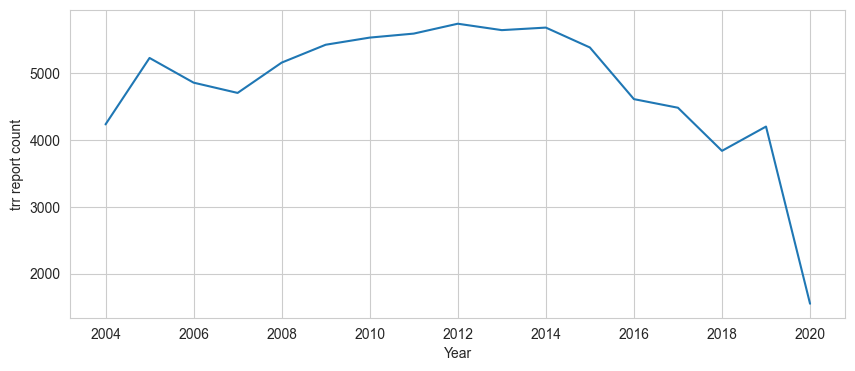

In [23]:
plotLine(df1, years)

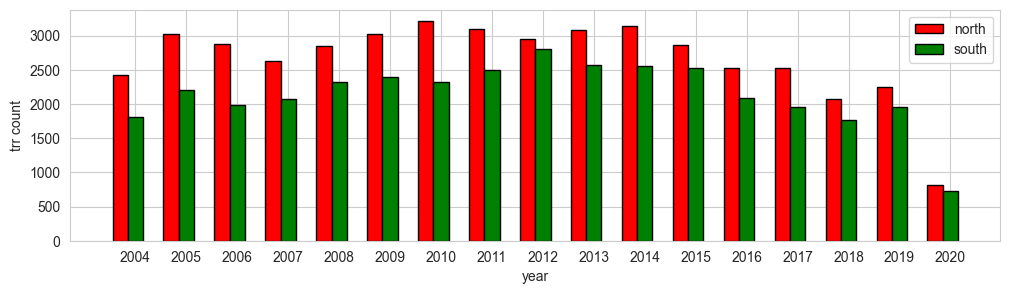

In [24]:
barNS(df0, years, "full_data_d0.jpg")

**Observation:**
It is interesting to note that in all cases multiple cases of complaint reports related to a single event comes usually from the north side. Overall, 2020 has far fewer trr reports. These could be because the data for 2020 is more recent and possibly lacking.

**Question** : *Can we use this information to create a reliable model that can predict the trr count per year?*

 We are going to use df2 for this part, which contains all the beat names and is categorized according to trr count per year per beat. We are going to define our goal first.

### **GOAL** : Predict the yearly trr count by city side.


**Question:** *Why are we using df2?* 

df0 only concerns with two columns : city side and trr count. This is a very small dataset and therefore not reliable enough to train our model. df2 however, is concerned with more detail- the beats. Therefore, this is more reliable to train our model. 

In [25]:
df2 = df2.drop(columns=['Unnamed: 0'])
df2.head(3)

,beat,count,years
0,1923,7,2004
2957,1922,3,2004
2966,211,7,2004


In [26]:
y = np.array(df2["count"])
X = np.array(df2[['beat', 'years']])
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=10)
print(len(X_train), '\n', len(X_test))

3540 
 885


Checking out a very simple model first! We are only using standard scaler followed by linear regression

In [27]:
X_tf = scalerST.fit_transform(X_train)
regrLinear.fit(X_tf, y_train)
metrics.r2_score(y_test, regrLinear.predict(X_test))


-144787.3818380805

This simple model performs VERY poorly. Can we improve?

In [28]:
random.seed(10)

pipelines = []
models = [('lreg', regrLinear), ('rreg', regrRidge), ('greg', regrGamma), ('sgdreg', regrSGD), ('kreg', regrKernal)]
results1 = {"model" : [], "best hparams": [], "best score": [], "features": [None]*10}
scaling_union = ('scaler', pipeline.FeatureUnion(scalers))
params = [{'lreg__positive': [True, False]},
          {'rreg__alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1], 'rreg__positive': [True, False]},
          {'greg__alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1], 'greg__warm_start': [True, False]},
          {'sgdreg__penalty': ['l2', 'l1', 'elasticnet'], 'sgdreg__learning_rate': ['optimal', 'invscaling', 'adaptive'], 'sgdreg__max_iter': [10000]},
          {'kreg__alpha': [0.00005, 0.0001, 0.0005, 0.001, 0.005], 'kreg__kernel': ["rbf"]}]


for i in range(len(models)):
    results1["model"].append(models[i][1])
    results1["model"].append(models[i][1])
    reg1 = pipeline.Pipeline(steps = [scaling_union, models[i]])
    reg2 = pipeline.Pipeline(steps =
                             [
                                 ('imputation', zeroImputer),
                                 ('column_one_hot',
                                   compose.ColumnTransformer([('categorical1', preprocessing.OneHotEncoder(), [0, 1])])
                                  ),
                                 models[i]
                             ]
    )
    grids1 = model_selection.GridSearchCV(reg1, param_grid=params[i], cv = 5)
    grids1.fit(X_train, y_train)
    best_estimator1 = grids1.best_estimator_
    score1 = model_selection.cross_val_score(best_estimator1, X_train, y_train, cv=5)
    score2 = model_selection.cross_val_score(reg2, X_train, y_train, cv = 5)
    reg2.fit(X_train, y_train)
    pipelines.append(best_estimator1)
    pipelines.append(reg2)
    best_estimator1.fit(X_train, y_train)
    results1["best score"].append(score1)
    results1["best score"].append(score2)
    results1["best hparams"].append(grids1.best_params_)
    results1["best hparams"].append("No tuning")
    print(i+1, '/', len(models))


resultdf = pd.DataFrame(results1)
print("View of one of the pipelines :")
pipelines[4]

1 / 5
2 / 5
3 / 5
4 / 5
5 / 5
View of one of the pipelines :


Pipeline(steps=[('scaler',
                 FeatureUnion(transformer_list=[('std', StandardScaler()),
                                                ('rb', RobustScaler())])),
                ('greg', GammaRegressor(alpha=0.01, warm_start=True))])

In [32]:
X_test,

array([[ 111, 2015],
       [ 722, 2008],
       [2512, 2020],
       ...,
       [ 324, 2019],
       [1833, 2015],
       [2523, 2014]], dtype=int64)

In [60]:
def get_counts(est, X_test, y_test, years):
    steps = est.steps
    imgName = '_'.join([*map(lambda step: step[0], steps)])

    y_pred = pd.DataFrame(est.predict(X_test)).rename(columns={0: 'count'})
    y_testdf = pd.DataFrame(y_test).rename(columns = {0: 'count'})

    X_testdf = pd.DataFrame(X_test).rename(columns={0: 'beat', 1: 'years'})
    X_testdf["side"] = X_testdf["beat"].apply(lambda x: conversion_dict[x])

    df_pred = pd.concat([X_testdf, y_pred], axis=1, join='inner')
    df_actual = pd.concat([X_testdf, y_testdf], axis=1, join='inner')

    print(df_pred)
    temp_pred = df_pred.groupby(['side', 'beat'])[['count']].mean().reset_index()
    temp_actual = df_actual.groupby(['side', 'beat'])[['count']].mean()

    temp_pred.columns = ['trr_count']
    temp_actual.columns = ['trr_count']

    df_pred = temp_pred.reset_index()
    df_actual = temp_actual.reset_index()
    score = metrics.r2_score(df_pred['count'], df_actual['count'])

    return (df_pred, df_actual, years, score)

In [61]:
corrected_results = []
df_pred, df_actual = None, None
for i in range(len(pipelines)):
    df_pred, df_actual, years, score = get_counts(pipelines[i], X_test, y_test, years)
    corrected_results.append(score)
    break
resultdf['best score'] = corrected_results
resultdf['features'] = ["beat, side"]*10
resultdf.to_csv("results\\result1.csv")
resultdf

     beat  years   side      count
0     111   2015  south  17.914062
1     722   2008  south  20.625000
2    2512   2020  north  14.242188
3     833   2011  south  19.226562
4     133   2017  south  17.171875
..    ...    ...    ...        ...
880   913   2016  south  17.000000
881  1135   2012  north  18.625000
882   324   2019  south  16.046875
883  1833   2015  north  16.914062
884  2523   2014  north  16.851562

[885 rows x 4 columns]


ValueError: Length mismatch: Expected axis has 3 elements, new values have 1 elements

Predicted trr report counts per year for beats included in test data using Kernal Ridge without tuning


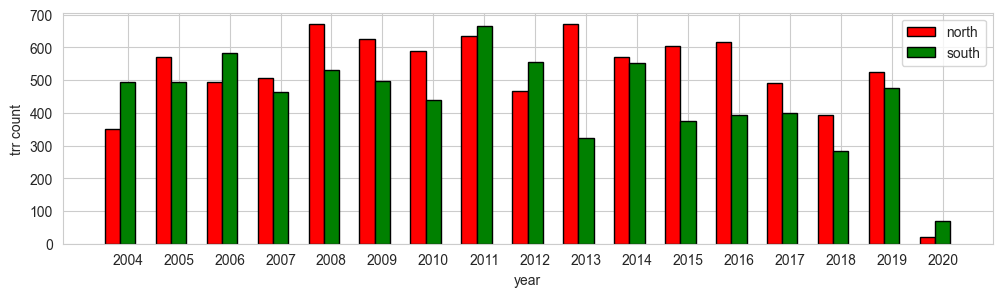

In [64]:
print("Predicted trr report counts per year for beats included in test data using Kernal Ridge without tuning")
barNS(df_pred, years, "predicted")

Actual trr counts per year for beats included in test data


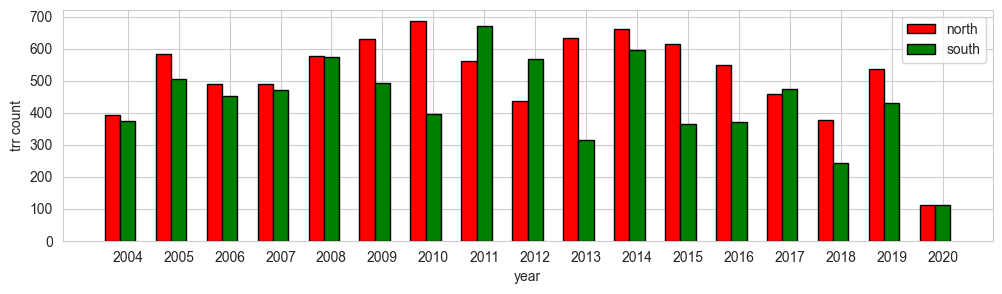

In [56]:
print("Actual trr counts per year for beats included in test data")
barNS(df_actual, years)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


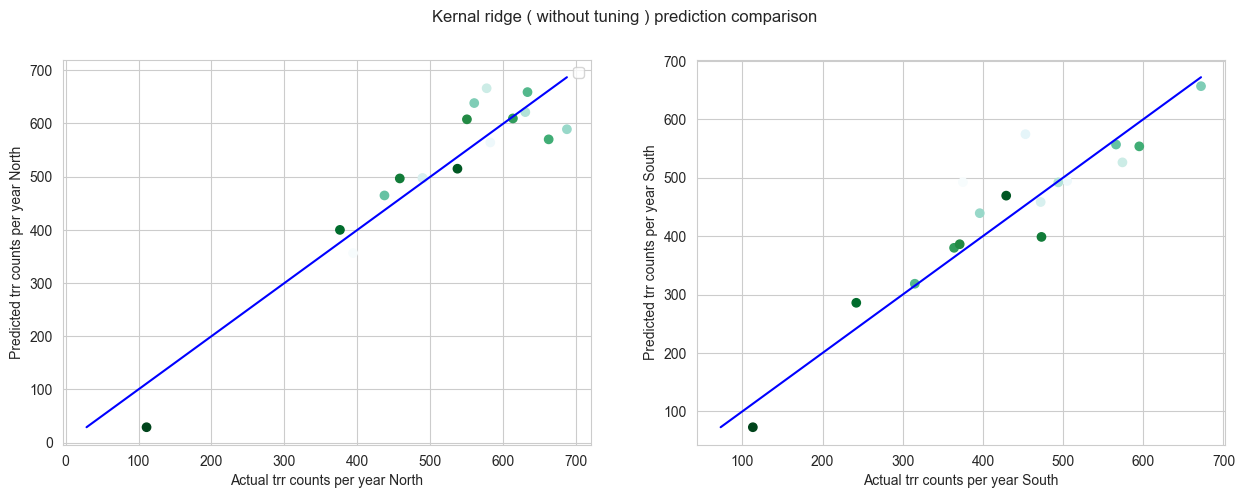

In [57]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
# plt.figure(figsize=(10,3))
ax1.scatter(df_actual[df_actual['side']=='north']['count'], df_pred[df_pred['side']=='north']['count'], c=years, alpha = 1)
p1 = max(max(df_actual[df_actual['side']=='north']['count']), max(df_pred[df_pred['side']=='north']['count']))
p2 = min(min(df_actual[df_actual['side']=='north']['count']), min(df_pred[df_pred['side']=='north']['count']))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set_xlabel('Actual trr counts per year North', fontsize=10)
ax1.set_ylabel('Predicted trr counts per year North', fontsize=10)

ax2.scatter(df_actual[df_actual['side']=='south']['count'], df_pred[df_pred['side']=='south']['count'], c=years, alpha = 1)
p1 = max(max(df_actual[df_actual['side']=='south']['count']), max(df_pred[df_pred['side']=='south']['count']))
p2 = min(min(df_actual[df_actual['side']=='south']['count']), min(df_pred[df_pred['side']=='south']['count']))
ax2.plot([p1, p2], [p1, p2], 'b-')
ax2.set_xlabel('Actual trr counts per year South', fontsize=10)
ax2.set_ylabel('Predicted trr counts per year South', fontsize=10)
ax1.legend()
plt.set_cmap('BuGn')
plt.suptitle("Kernal ridge ( without tuning ) prediction comparison")
plt.savefig("scatterplot_kernalRidge_no_tuning")
plt.show()

<br>
<br>

### Further experimentation with kernal ridge

In [58]:
params = {'alpha': 5e-05, 'kernel': 'rbf'}
regrKernal.set_params(**params)

KernelRidge(alpha=5e-05, kernel='rbf')

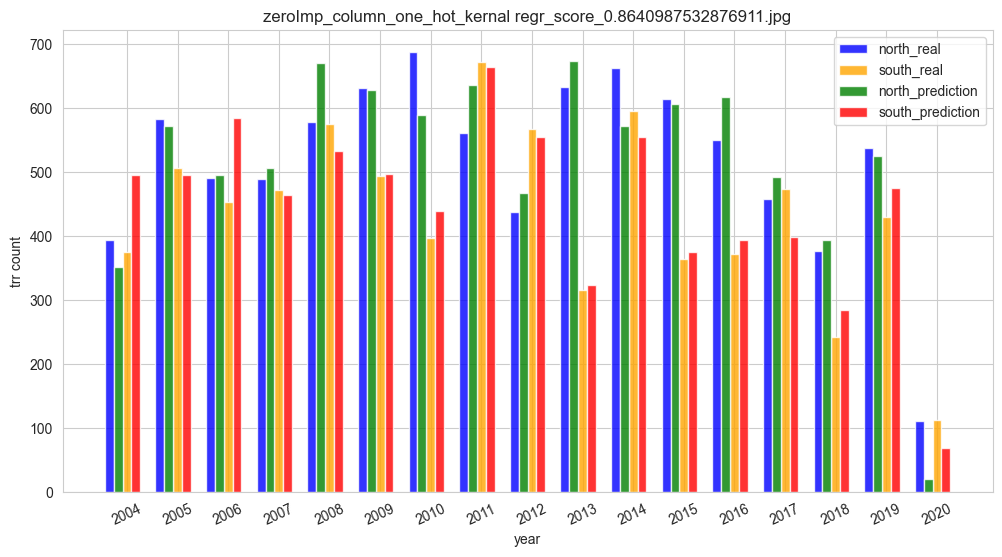

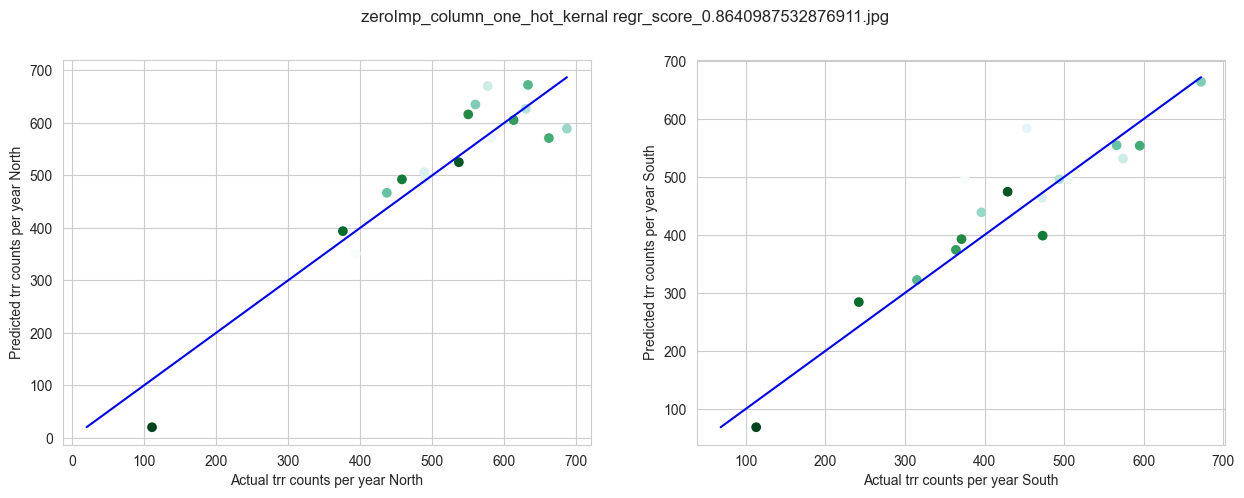

In [59]:
pipeline_kernalR = pipeline.Pipeline(steps =
[
    ('zeroImp', zeroImputer),
    ('column_one_hot',
     compose.ColumnTransformer([('categorical1', preprocessing.OneHotEncoder(), [0, 1])])
     ),
    ('kernal regr', regrKernal)
]
)

# score_kr = np.mean(model_selection.cross_val_score(pipeline_kernalR, X_train, y_train, cv=5))
pipeline_kernalR.fit(X_train, y_train)
df_pred, df_actual, years, score = get_counts(pipeline_kernalR, X_test, y_test, years)
# tuning does not improve scores here


### Question for later

How can we improve now? We will try to do a regression task with trr_count from trr_trr as target. We will use xgboost classifier as it is very efficient and applies gradient boosting. One of the advantages of using XGBoost is that it handles missing data without requiring external imputation.

Let us use a bit more information. We will try to use some historic officer info to predict trr_counts in a year a particular beat. We are going to now perform a few more sql queries for that. The idea is that if we have all the information of the officers in their respective beats then we should be able to detect a pattern in trr_counts.

In [61]:
filename = 'console2.sql'
_, tables = table_from_file(filename)

1 tables received


In [62]:
''.join(tables['t0']['sql'].split('\n'))

'        select * from officer_trr        '

In [63]:
df3 = tables['t0']['frame']

In [64]:
df3.groupby('beat')['point'].agg(pd.Series.mode)

beat
0                                (-87.6956754,41.8592766)
111                              (-87.6281289,41.8846053)
112                              (-87.6277713,41.8808681)
113                                (-87.628048,41.877113)
114                               (-87.5856334,41.805977)
                              ...                        
2533                             (-87.7549489,41.9095693)
2534    [(-87.7313878,41.9038389), (-87.7332847,41.905...
2535                             (-87.7234783,41.9102371)
3100                             (-87.6297982,41.8781136)
4100    [(-87.521962,41.6004191), (-87.5248443,41.7025...
Name: point, Length: 305, dtype: object

In [65]:
beats = df3[['beat']]
newBeats= kneighbours(beats['beat'])
df3 = df3.drop(columns = ['beat'])
df3['beat'] = newBeats


In [66]:
df3_side = df3['beat'].apply(lambda x: conversion_dict[int(x)])
df3['side'] = df3_side
df3.to_csv('tables\\df3.csv')

In [66]:
df3 = pd.read_csv('tables\\df3.csv', low_memory = False).drop(columns = ['Unnamed: 0'])
df3 = df3.drop(columns = ['point'])

In [67]:
unknown = df3[df3['trr_count'] == np.nan]
df3 = df3.dropna(axis=0, how = 'any', subset = ['trr_count']).reset_index()
df3['appointed_date'] = df3['appointed_date'].astype('str').apply(lambda x: x.split('-')[0]).astype('int64')
y = df3[['trr_count']]
print(df3.info())
ycol = 'trr_count'
xcols = [ col for col in df3.columns if col!=ycol]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83118 entries, 0 to 83117
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           83118 non-null  int64  
 1   active                          83118 non-null  object 
 2   allegation_count                83118 non-null  float64
 3   appointed_date                  83118 non-null  int64  
 4   birth_year                      83117 non-null  float64
 5   civilian_allegation_percentile  79346 non-null  float64
 6   civilian_compliment_count       83118 non-null  float64
 7   complaint_percentile            79346 non-null  float64
 8   discipline_count                83118 non-null  float64
 9   gender                          83118 non-null  object 
 10  honorable_mention_count         83118 non-null  float64
 11  honorable_mention_percentile    80836 non-null  float64
 12  id                              

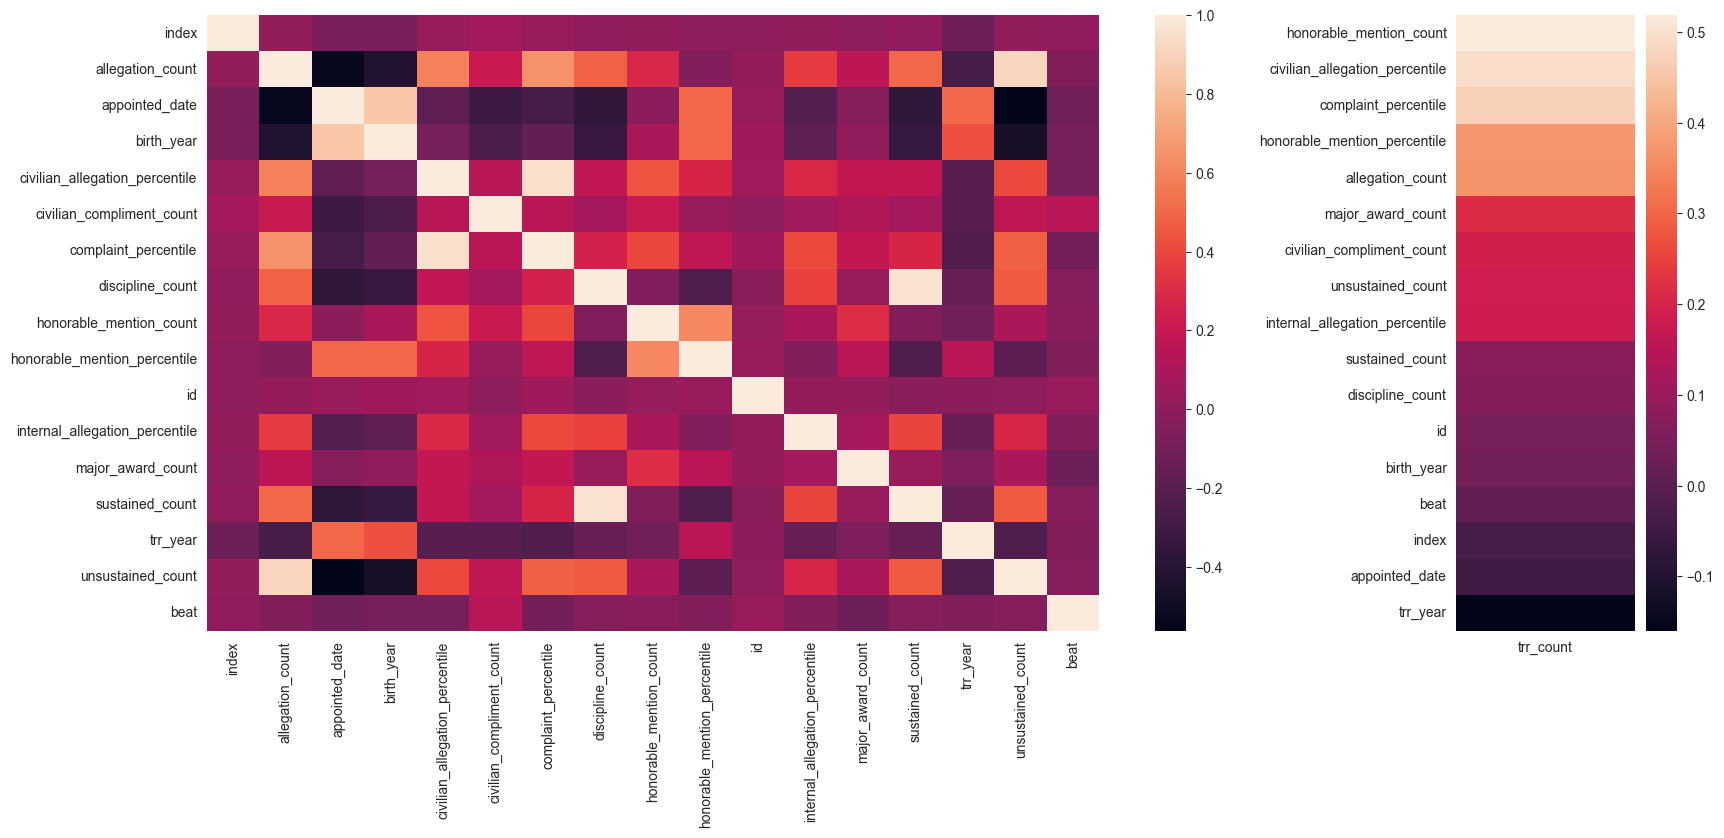

In [68]:
import seaborn as sns
num_df = df3[xcols].select_dtypes(['int64', 'float64'])
corr_matrix = num_df.corr()
corr_with_target = num_df.apply(lambda x: x.corr(df3[ycol]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (19, 8), gridspec_kw={'width_ratios': [5, 1]})
sns.heatmap(corr_matrix, ax=ax1)
sns.heatmap(pd.DataFrame(corr_with_target, index = num_df.columns, columns=[ycol]).sort_values(by = ycol, ascending=False), ax = ax2)

# removing some of the unrelated columns from the heatmap
drop = ['birth_year', 'appointed_date', 'id', 'discipline_count', 'sustained_count', 'internal_allegation_percentile', 'unsustained_count']
df3 = df3.drop(columns = drop)
xcols = [ col for col in df3.columns if col!=ycol]
plt.show()

- trr_count moderately correlated with: honorable mention count, civilian allegation percentile, complaint percentile ( none of these columns are strongly correlated to each other )

In [71]:
cat = df3[xcols].select_dtypes(['object']).columns.to_list()
print('Categorical columns : ', cat)
oh1 = preprocessing.OneHotEncoder(sparse = False)
df3_cat = oh1.fit_transform(df3[cat])
feature_names = list(oh1.get_feature_names_out())
df3_cat = pd.DataFrame(df3_cat, columns = feature_names)
df3_enc = df3.drop(columns = cat)
df3_enc = pd.concat([df3_cat, df3_enc], axis = 1)

KeyError: "['active_No', 'active_Unknown', 'active_Yes', 'gender_F', 'gender_M', 'race_Asian/Pacific', 'race_Black', 'race_Hispanic', 'race_Native American/Alaskan Native', 'race_Unknown', 'race_White', 'rank_Assistant Superintendent', 'rank_CAPS Coordinator', 'rank_Captain of Police', 'rank_Chief', 'rank_Clerk IV', 'rank_Commander', 'rank_Crossing Guard', 'rank_Deputy Chief', 'rank_Deputy Director', 'rank_Deputy Superintendent', 'rank_Detective', 'rank_Detention Aide', 'rank_Evidence Tech', 'rank_Explosives Tech I', 'rank_First Deputy Superintendent', 'rank_Gang Crimes', 'rank_Lab Tech III', 'rank_Lieutenant of Police', 'rank_Police Administrative Clerk', 'rank_Police Agent', 'rank_Police Cadet', 'rank_Police Dispatcher', 'rank_Police Dispatcher Aide', 'rank_Police Forensic Investigator I', 'rank_Police Officer', 'rank_Police Officer (Per Arbitration Award)', 'rank_Police Officer / Explosives Detective Canine Handler', 'rank_Police Officer / Field Training Officer', 'rank_Police Officer / Marine Officer', 'rank_Police Officer / Mounted Patrol Officer', 'rank_Police Officer Assign Youth Off', 'rank_Police Officer Assigned Canine Handler', 'rank_Police Officer Assigned Evidence Technician', 'rank_Police Officer Assigned Latent Fingerprint Examiner', 'rank_Police Officer Assigned Security Specialist', 'rank_Police Officer Assigned Traffic Specialist', 'rank_Police Officer Assigned as Helicopter Pilot', 'rank_Police Officer as Detective', 'rank_Police Technician', 'rank_Remote Terminal Operator', 'rank_SR Public Safety Aide', 'rank_Sergeant', 'rank_Sergeant Assigned Security Specialist', 'rank_Sergeant Per Arbitration', 'rank_Sergeant of Police', 'rank_Superintendent of Police', 'rank_Unknown', 'rank_nan', 'side_north', 'side_south'] not in index"

In [ ]:
xcols = [col for col in df3_enc.columns.to_list() if col != ycol]

In [72]:
df3_enc = df3_enc[xcols].fillna(value = np.nan)
print(df3.shape)

(83118, 16)


In [74]:
from xgboost import XGBRegressor

X = df3_enc.drop(columns = ['index'])
print(X.shape)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y['trr_count'], test_size = 0.20)
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

0.9110631755651604

(83118, 70)


0.9145694230771383

In [75]:
"   score: 0.9201675561188993    "

'   score: 0.9201675561188993    '

In [76]:
y_pred = xgb.predict(X_test)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
MAE = metrics.mean_absolute_error(y_test, y_pred)
print('RMSE : ', RMSE)
print('MAE : ', MAE)


RMSE :  3.422526234911578
MAE :  2.5238841370241003


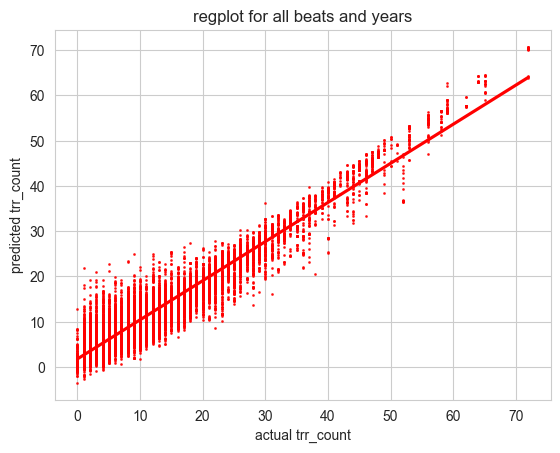

In [77]:
sns.regplot(x = y_test, y = y_pred, color='red', scatter_kws={'s':1})
plt.xlabel('actual trr_count')
plt.ylabel('predicted trr_count')
plt.title('regplot for all beats and years')
plt.show()

In [78]:
a = df3.loc[list(X_test.index)][['beat', 'side', 'trr_year']]
b = y.loc[list(X_test.index)]

result_df = pd.concat([a, b], axis = 1)
result_df['predicted'] = y_pred
result_df = result_df.groupby(['side', 'trr_year'])[['trr_count', 'predicted']].sum().reset_index()
result_df.head()
result_df.to_csv('tables\\resultBySide.csv')

In [79]:
result_df

,side,trr_year,trr_count,predicted
0,north,2004,6146.0,6206.596191
1,north,2005,8777.0,8835.359375
2,north,2006,9237.0,9229.551758
3,north,2007,8066.0,8077.833008
4,north,2008,9394.0,9416.306641
5,north,2009,9551.0,9685.439453
6,north,2010,10145.0,10272.751953
7,north,2011,10222.0,10371.425781
8,north,2012,9220.0,9214.977539
9,north,2013,8818.0,8893.439453


In [80]:
score = metrics.r2_score(result_df['trr_count'], result_df['predicted'])
RMSE = np.sqrt(metrics.mean_squared_error(result_df['trr_count'], result_df['predicted']))
MAE = metrics.mean_absolute_error(result_df['trr_count'], result_df['predicted'])
print('Score : ', score)
print('RMSE : ', RMSE)
print('MAE : ', MAE)

Score :  0.9991692521913963
RMSE :  82.51516756960363
MAE :  67.91580379710479


### Feature Importance

In [81]:
import shap

explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


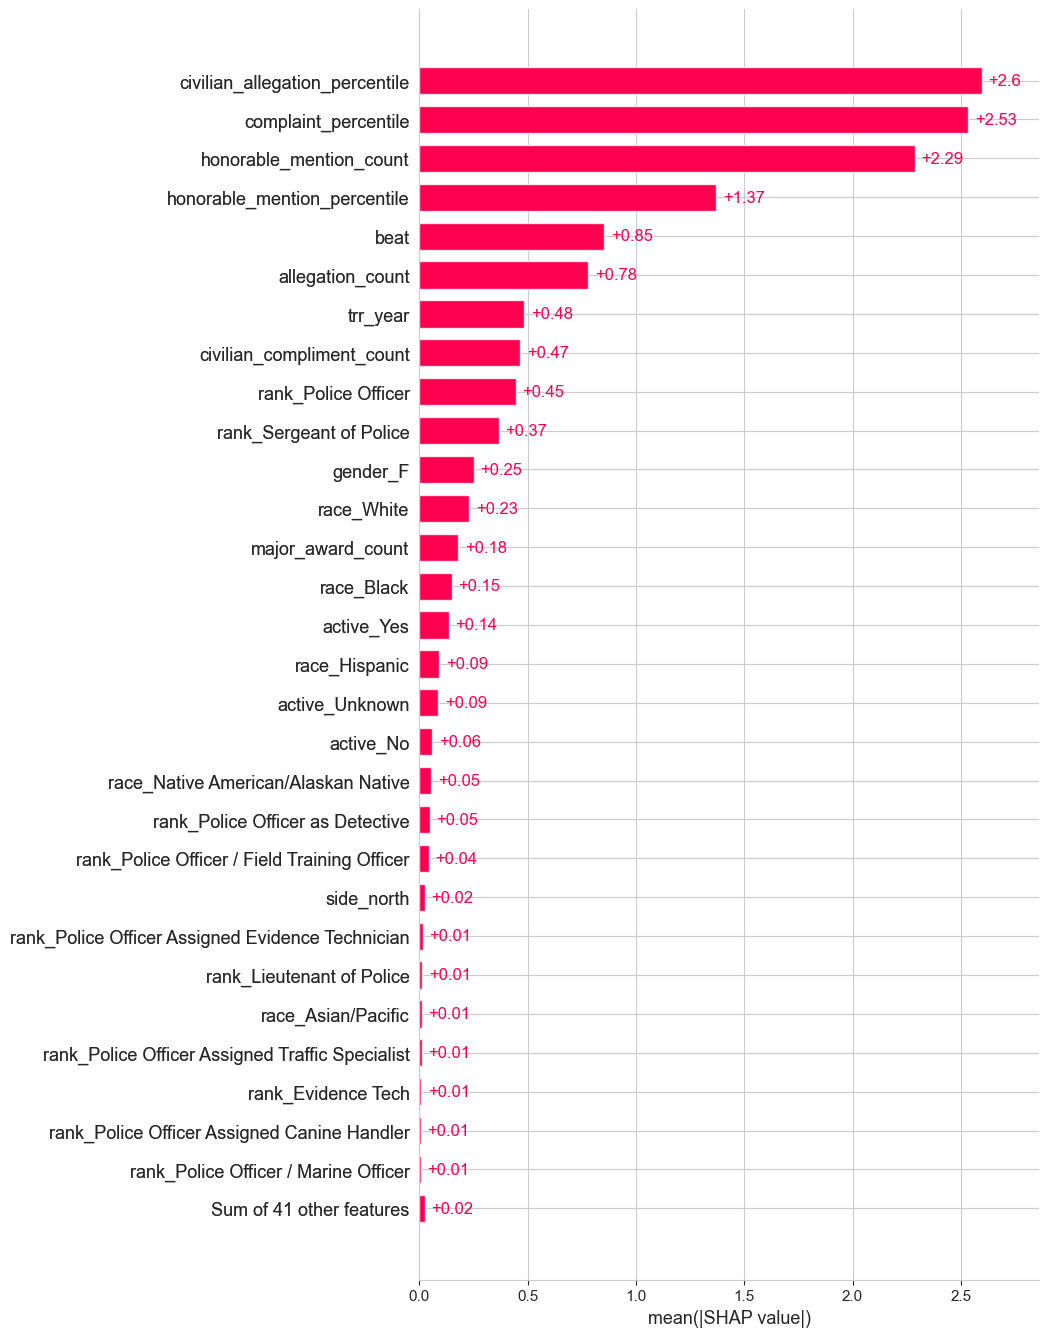

In [82]:
shap.plots.bar(shap_values, max_display=30)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


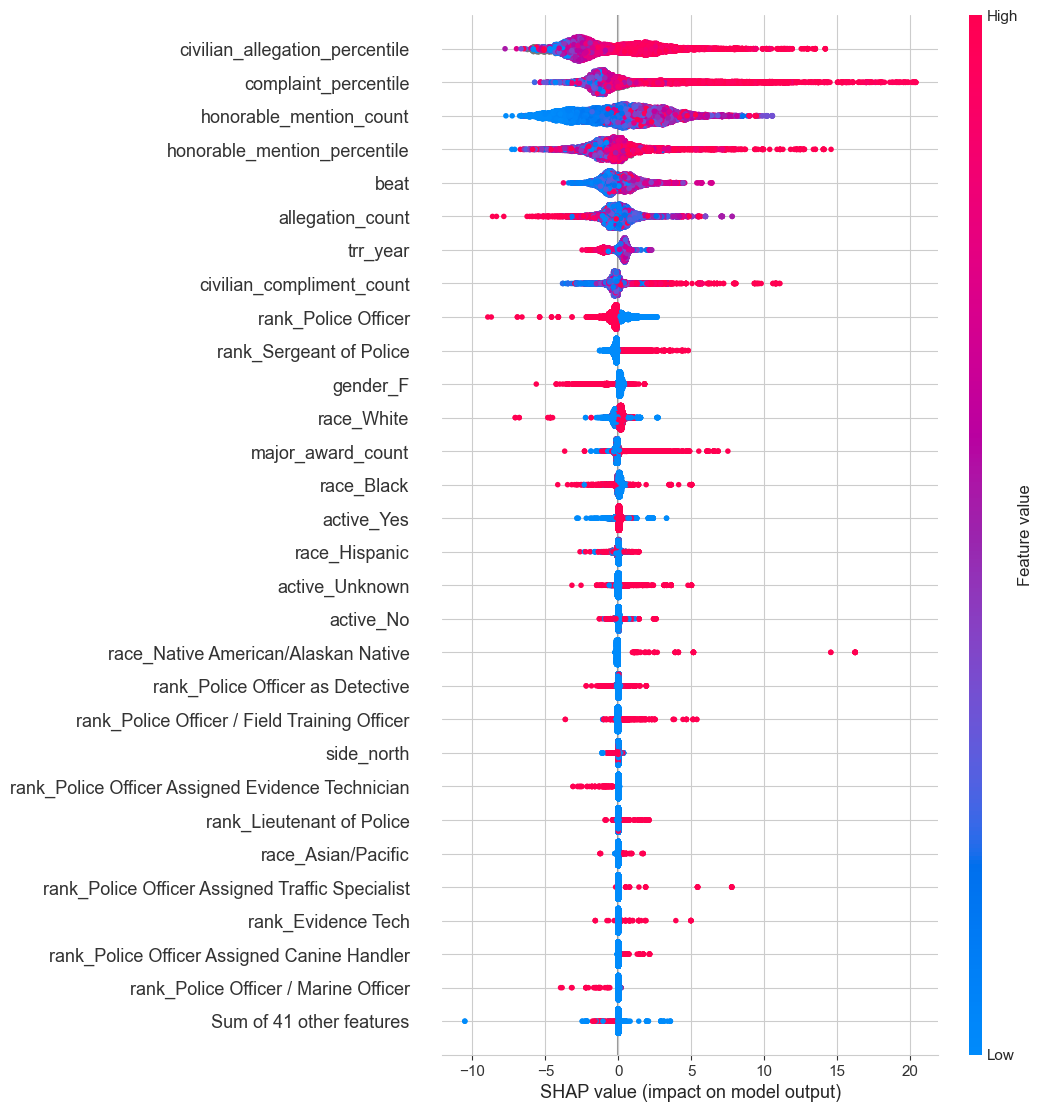

In [83]:
shap.plots.beeswarm(shap_values, max_display = 30)

In [ ]:
shap.plots.heatmap(shap_values, max_display = 30)
